# May 2019 JLab Lunch

## Sep. 19, 2020

## Questions:

How to save History.history after a model.fit() call

Does it always reset if you switch to GPU

Can you store files or do you always have to load them?

In [1]:
# Variables

TRAIN_SAMPLE = 10000
TEST_SAMPLE = 25
EPOCHS = 50

## Before model setup

### Download data

In [2]:
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
! pip install pypng

--2020-09-29 20:06:00--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31813265 (30M) [application/x-gzip]
Saving to: ‘images.raw.gz’

images.raw.gz       100%[===================>]  30.34M  22.3MB/s    in 1.4s    

2020-09-29 20:06:01 (22.3 MB/s) - ‘images.raw.gz’ saved [31813265/31813265]

--2020-09-29 20:06:02--  https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38940211 (37M) [text/csv]
Saving to: ‘track_parms.csv’

track_parms.csv     100%[===================>]  37.14M  26.0MB/s    in 1.4s    

2020-09-29 20:06:03 (26.0 MB/s) - ‘track_

### Extract images from file

In [3]:
import png
import os
import sys

import requests
import gzip
import numpy as np
import pandas as pd
from tensorflow import keras


MAX_IMG_USED = TRAIN_SAMPLE + TEST_SAMPLE



def loadImages(amount):
  # from https://halldweb.jlab.org/talks/ML_lunch/May2019/raw2png.py

  #------------------ input parameters --------------------
  width = 36
  height = 100

  iMIN = 0    # First image to grab starting from zero
  iNUM = amount  # Number of images to grab

  idx_fname = 'track_parms.csv'
  outputdir = './images'
  #--------------------------------------------------------

  # Read in file names if index file if present
  fnames = []
  if os.path.exists( idx_fname ):
    df = pd.read_csv( idx_fname )
    fnames = df.filename

  # Make sure output directory exists
  if not os.path.exists(outputdir): os.mkdir( outputdir )

  # Open gzipped images file and loop over images
  Ncreated = 0
  with gzip.open('images.raw.gz') as f:

    # Skip iMIN images at front of file
    if iMIN>0:
      print('Skipping %d images ...' % iMIN)
      f.read(width*height*iMIN)
        
    # Create images from next iNUM records
    print('Creating %d images in %s ...' % (iNUM, outputdir))
    for i in range(0,iNUM):

      # Read record and make it the right shape
      bytes = f.read(width*height)
      if len(bytes) != (width*height):
        print('\n File truncated!')
        break
      data = np.frombuffer(bytes, dtype='B', count=width*height)
      pixels = np.reshape(data, [height, width])
      
      # Image name
      idx = i + iMIN
      fname = 'img%06d.png' % idx 
      if idx < len(fnames): fname = fnames[idx]
      
      # Create image file
      png.fromarray(pixels, 'L').save( outputdir + '/' + fname )

      # Bookkeeping
      Ncreated += 1
      if (Ncreated%10) == 0:
        sys.stdout.write(' created %d/%d images\r' % (Ncreated,iNUM))
        sys.stdout.flush()

  print('Created ' + str(Ncreated) + ' image files')
  print('Done')

loadImages(MAX_IMG_USED)

Creating 10025 images in ./images ...
Created 10025 image files
Done


### Imports, reading in images, and setting up data

In [4]:
import requests
import gzip
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

min_img = 0
min_y = 0
# returns normalized image array for given amout, does not reuse previous images
# amout = size of array needed
def getImgs(amount):
  global min_img
  data_x = np.zeros([amount,100,36])
  for index, i in enumerate(data_x):
    path = "./images/img" + "{:06}".format(index+min_img) + ".png"
    data_x[index] = keras.preprocessing.image.load_img(path,color_mode="grayscale")
    for indy,y in enumerate(data_x[index]):
      for indx, x in enumerate(y):
        data_x[index,indy,indx] /= 255.
  return data_x
    


train_x = getImgs(TRAIN_SAMPLE)
min_img = len(train_x)
# full_y = pd.read_csv("https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv")
full_y = pd.read_csv("./track_parms.csv")

def setup_data(datax,useLargest=False):
  global min_y
    # restrict size to what you have in datax
  datay = full_y[min_y:min_y+len(datax)]
    # restrict to only z and phi
  datay = np.array(datay.to_numpy()[:,1:3]).astype(np.float32)
  datay = datay.astype(np.float32)

  # expand to show that it is a gray scale not RGB to keras ¯\_(ツ)_/¯
  datax = np.expand_dims(datax,axis=-1)
  datax = datax.astype(np.float32)

  return (datax,datay)

(train_x,train_y) = setup_data(train_x)
min_y = len(train_x)

print(train_x.shape)
print(train_y.shape)

        

(10000, 100, 36, 1)
(10000, 2)


## Build 2 branch model for z and phi

### Branch building

In [5]:
def buildBranch(input,str1):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D()(x)

  x = keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D()(x)
  
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1,activation="linear",name=str1)(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch_z = buildBranch(inputs,"z")
branch_phi = buildBranch(inputs,"phi")
model = keras.Model(inputs=inputs, outputs={"z":branch_z, "phi":branch_phi}, name="detector")
losses = {
    "z":"mse",
    "phi":"mse"
}
lossWeights = 1.0
opt = "adam"
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["mae"])
model.summary()
print(train_y.shape)

# model.summary()
# # model.compile(optimizer=keras.optimizers.Adam, loss=keras.losses.categorical_crossentropy)
# model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics='accuracy')
# # model.compile(optimizer='Adam', loss=keras.losses.,metrics='accuracy')
# model.fit(train_x,train_y,batch_size=32,epochs=50,verbose=1)


Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 34, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 34, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 98, 34, 32)   128         conv2d_2[0][0]                   
___________________________________________________________________________________________

### Train model

In [6]:
H = model.fit(x=train_x, y={"z":train_y[:,0], "phi":train_y[:,1]}, epochs=EPOCHS, verbose=0)
model.save("model.keras",save_format="h5")

In [7]:
print(H.history.keys())

dict_keys(['loss', 'phi_loss', 'z_loss', 'phi_mae', 'z_mae'])


### Plot loss and mae

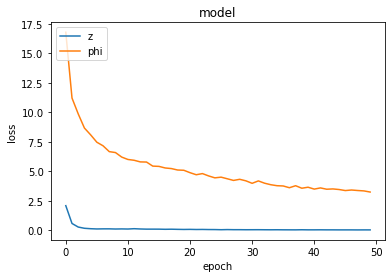

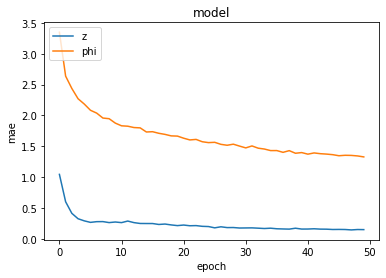

In [10]:

plt.plot(H.history['z_loss'])
plt.plot(H.history['phi_loss'])
plt.title('model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['z','phi'],loc='upper left')
plt.show()
plt.plot(H.history['z_mae'])
plt.plot(H.history['phi_mae'])
plt.title('model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['z','phi'],loc='upper left')
plt.show()


### Validate data and show difference

In [9]:
test_x = getImgs(TEST_SAMPLE)
(test_x,test_y) = setup_data(test_x,True)

ev = model.evaluate(x=test_x,y=test_y,batch_size=32)
print("net  loss: {:5.2f}\nz:   loss: {:5.2f} mae:{:5.2f}\nphi: loss: {:5.2f} mae:{:5.2f}".format(ev[0],ev[1],ev[3],ev[2],ev[4]))



ans1 = model.predict(test_x)
ans = np.asarray([ans1["z"],ans1["phi"]])
ans = np.squeeze(ans)
print("prediction shape:",ans.shape,"\n")
print("true: z     phi   : pred:   z     phi  :        z     phi")
for (t,z,phi) in zip(test_y[:20],ans[0,:20],ans[1,:20]):
  print("   {:6.3f},{:6.3f}".format(t[0],t[1])," : ","    {:6.3f},{:6.3f}".format(z,phi)," : ","  {:5.2f},{:5.2}".format(z-t[0],phi-t[1]))


1/1 [==============================] - 0s 2ms/step - loss: 50.3753 - phi_loss: 22.9923 - z_loss: 27.3830 - phi_mae: 3.1440 - z_mae: 3.1468
net  loss: 50.38
z:   loss: 22.99 mae: 3.14
phi: loss: 27.38 mae: 3.15
prediction shape: (2, 25) 

true: z     phi   : pred:   z     phi  :        z     phi
    2.674, 5.344  :       2.728, 3.939  :     0.05, -1.4
    7.178,-4.918  :       7.519,-4.162  :     0.34, 0.76
   -7.382,-0.411  :      -7.344,-0.618  :     0.04,-0.21
   -9.922, 6.201  :      -10.277, 5.833  :    -0.35,-0.37
   -9.664, 3.771  :      -10.070, 2.880  :    -0.41,-0.89
   -0.463, 3.752  :      -0.409, 1.359  :     0.05, -2.4
    1.349, 5.474  :       1.265, 2.488  :    -0.08, -3.0
    4.347,-3.238  :       4.507,-3.336  :     0.16,-0.099
   -7.091,-1.302  :      -7.151,-1.479  :    -0.06,-0.18
   -4.344, 5.872  :      -4.543, 3.853  :    -0.20, -2.0
   -0.627, 5.989  :      -0.576, 3.422  :     0.05, -2.6
    8.597, 4.432  :       8.916, 4.061  :     0.32,-0.37
    6.095,-6.724 

## Build single branch model with output [z,phi]

In [11]:
def buildBranch(input):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((3,3))(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((3,3))(x)
  x = keras.layers.Dropout(0.25)(x)
  
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Dense(1,activation="linear")(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch = buildBranch(inputs)
model = keras.Model(inputs=inputs, outputs=branch, name="detector")
losses = "mse"
lossWeights = 1.0
opt = "adam"
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["mae"])
model.summary()
print(train_y.shape)

Model: "detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 36, 1)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 98, 34, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 98, 34, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 98, 34, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 96, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 10, 32)        0  

### Train model

In [12]:
H = model.fit(x=train_x, y=train_y, epochs=EPOCHS, verbose=0)
model.save("model.keras",save_format="h5")

### Plot loss and mae

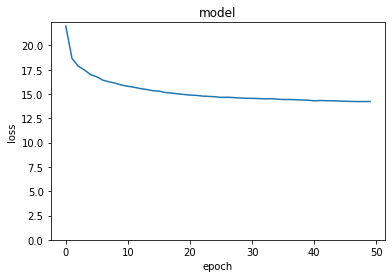

In [13]:
plt.plot(H.history['loss'])
plt.title('model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(bottom=0)
plt.show()

### Validate data and show difference

In [14]:
test_x = getImgs(TEST_SAMPLE)
(test_x,test_y) = setup_data(test_x,True)

ev = model.evaluate(x=test_x,y=test_y,batch_size=32)
print("net  loss: {:5.2f} mae: {:5.2f}".format(ev[0],ev[1]))


ans1 = model.predict(test_x)
print("prediction shape:",ans.shape,"\n")
print("true: z     phi   : pred:   z     phi  :        z     phi")
for (t,z,phi) in zip(test_y[:20],ans[0,:20],ans[1,:20]):
  print("   {:6.3f},{:6.3f}".format(t[0],t[1])," : ","    {:6.3f},{:6.3f}".format(z,phi)," : ","  {:5.2f},{:5.2}".format(z-t[0],phi-t[1]))


1/1 [==============================] - 0s 1ms/step - loss: 14.2755 - mae: 3.0794
net  loss: 14.28 mae:  3.08
prediction shape: (2, 25) 

true: z     phi   : pred:   z     phi  :        z     phi
    2.674, 5.344  :       2.728, 3.939  :     0.05, -1.4
    7.178,-4.918  :       7.519,-4.162  :     0.34, 0.76
   -7.382,-0.411  :      -7.344,-0.618  :     0.04,-0.21
   -9.922, 6.201  :      -10.277, 5.833  :    -0.35,-0.37
   -9.664, 3.771  :      -10.070, 2.880  :    -0.41,-0.89
   -0.463, 3.752  :      -0.409, 1.359  :     0.05, -2.4
    1.349, 5.474  :       1.265, 2.488  :    -0.08, -3.0
    4.347,-3.238  :       4.507,-3.336  :     0.16,-0.099
   -7.091,-1.302  :      -7.151,-1.479  :    -0.06,-0.18
   -4.344, 5.872  :      -4.543, 3.853  :    -0.20, -2.0
   -0.627, 5.989  :      -0.576, 3.422  :     0.05, -2.6
    8.597, 4.432  :       8.916, 4.061  :     0.32,-0.37
    6.095,-6.724  :       6.304,-5.400  :     0.21,  1.3
   -1.010,-7.384  :      -0.998,-3.493  :     0.01,  3.9
    